In [1]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt

We will now analyze quickly the data from Physionet. 

In [18]:
record_name = '19830'
record = wfdb.rdrecord(record_name)
print(record.__dict__)

{'record_name': '19830', 'n_sig': 2, 'fs': 128, 'counter_freq': None, 'base_counter': None, 'sig_len': 10701824, 'base_time': datetime.time(9, 56), 'base_date': None, 'comments': ['50 F'], 'sig_name': ['ECG1', 'ECG2'], 'p_signal': array([[-0.435, -0.425],
       [-0.435, -0.415],
       [-0.415, -0.405],
       ...,
       [-0.1  ,  0.   ],
       [-0.09 ,  0.   ],
       [-0.1  ,  0.   ]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['19830.dat', '19830.dat'], 'fmt': ['212', '212'], 'samps_per_frame': [1, 1], 'skew': [None, None], 'byte_offset': [None, None], 'adc_gain': [200.0, 200.0], 'baseline': [0, 0], 'units': ['mV', 'mV'], 'adc_res': [12, 12], 'adc_zero': [0, 0], 'init_value': [-87, -85], 'checksum': [4579, -29057], 'block_size': [0, 0]}


We have two channels, that correspond to the two electrodes. We will plot a short sequence of 10 seconds of both channels

In 10 seconds, we have 1280 samples.


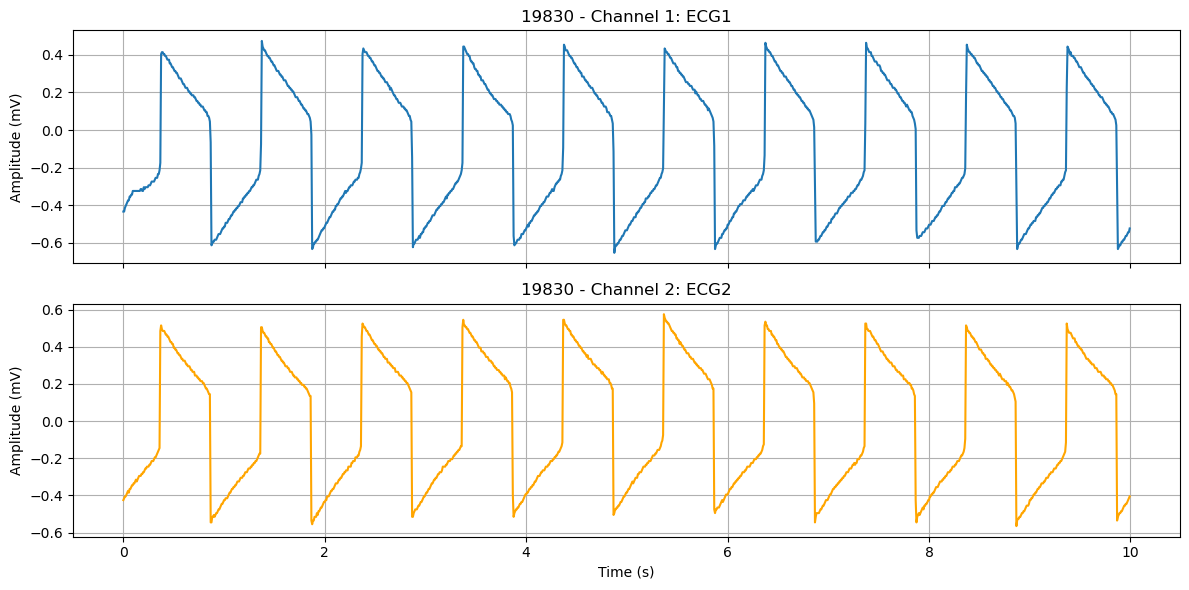

In [41]:
record_name = '19830'
record = wfdb.rdrecord(record_name)
signal = record.p_signal
fs = record.fs
seconds = 10
samples = int(fs * seconds)
time = np.arange(samples) / fs
print(f"In {seconds} seconds, we have {samples} samples.")

fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
axs[0].plot(time[:samples], signal[:samples, 0])
axs[0].set_title(f"{record_name} - Channel 1: {record.sig_name[0]}")
axs[0].set_ylabel("Amplitude (mV)")
axs[0].grid(True)
axs[1].plot(time[:samples], signal[:samples, 1], color='orange')
axs[1].set_title(f"{record_name} - Channel 2: {record.sig_name[1]}")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Amplitude (mV)")
axs[1].grid(True)
plt.tight_layout()
plt.show()


We need 80 datapoints, but if we take 10 seconds, we have 1280 samples. If we just take 80 samples, the time window will be too small. So we will downsample the data by a factor of 8, and see if we can still see the same patterns.

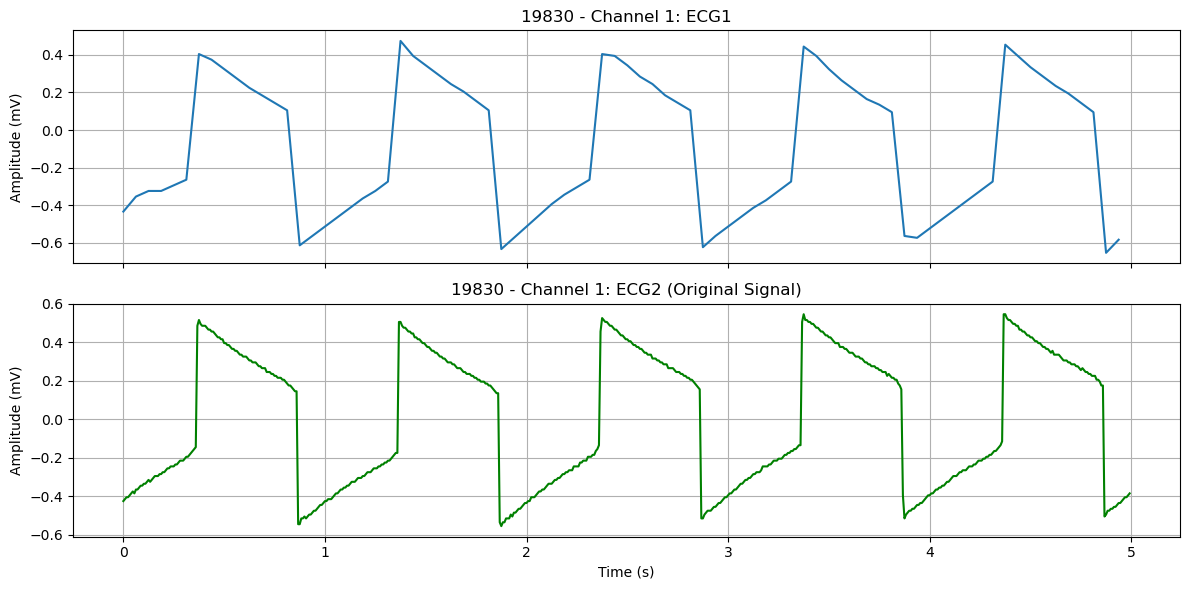

In [39]:
signal_downsampled = signal[:samples, :][::8]
time_downsampled = time[:samples][::8]
channel_1_downsampled = signal[:samples, 1][::8]

signal_downsampled = signal_downsampled[:80]
time_downsampled = time_downsampled[:80]
channel_1_downsampled = channel_1_downsampled[:80]

fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
axs[0].plot(time_downsampled, signal_downsampled[:, 0])
axs[0].set_title(f"{record_name} - Channel 1: {record.sig_name[0]}")
axs[0].set_ylabel("Amplitude (mV)")
axs[0].grid(True)
time = time[:samples // 2]
signal = signal[:samples // 2, :]
axs[1].plot(time[:samples], signal[:samples, 1], color='green')
axs[1].set_title(f"{record_name} - Channel 1: {record.sig_name[1]} (Original Signal)")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Amplitude (mV)")
axs[1].grid(True)
plt.tight_layout()
plt.show()


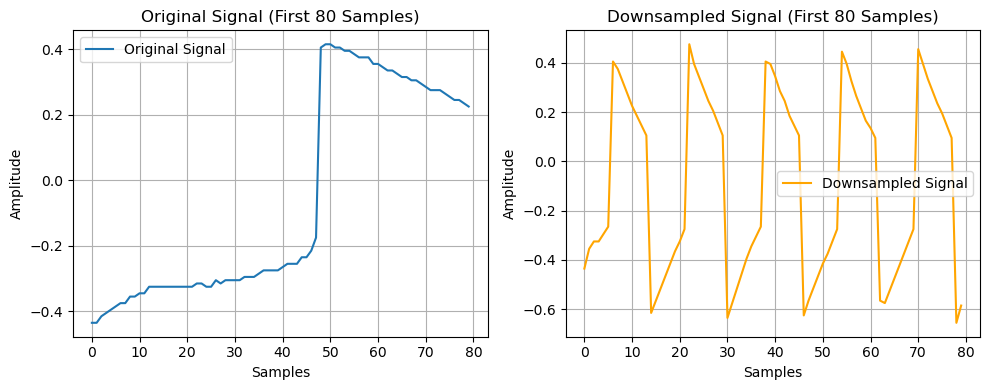

In [5]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(signal[:80, 0], label='Original Signal')
plt.title('Original Signal (First 80 Samples)')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(signal_downsampled[:80, 0], label='Downsampled Signal', color='orange')
plt.title('Downsampled Signal (First 80 Samples)')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Downsampling by a factor of 8 does not affect the shape of the signal.

We now plot the entire signal, to check if the signal is clean

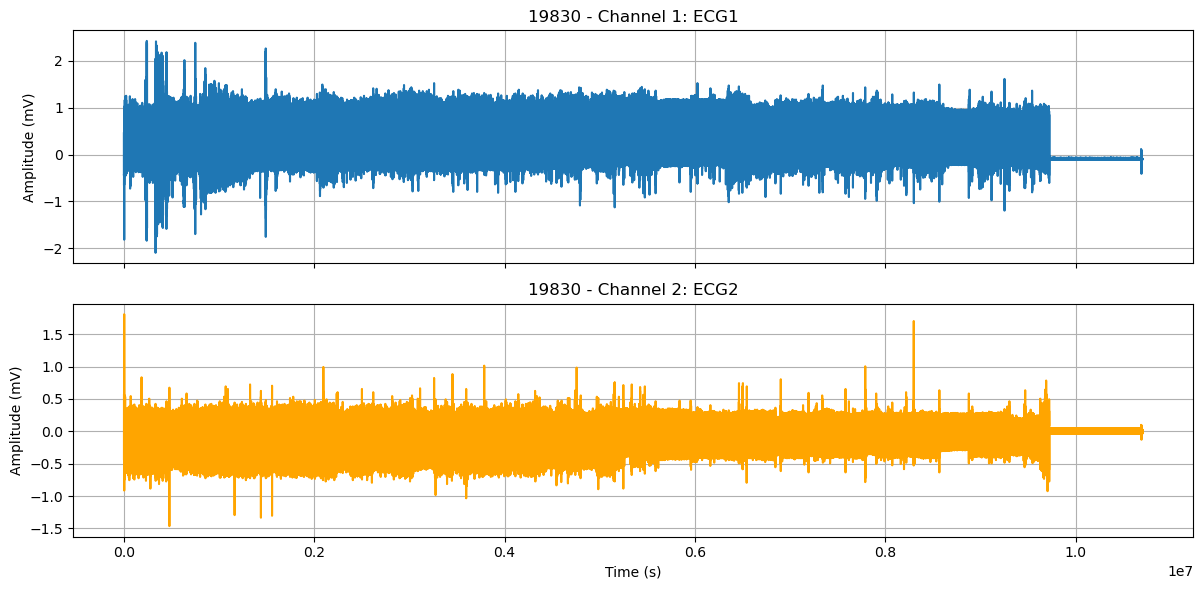

In [43]:
time = np.arange(len(signal)) 
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axs[0].plot(time, signal[:, 0])
axs[0].set_title(f"{record_name} - Channel 1: {record.sig_name[0]}")
axs[0].set_ylabel("Amplitude (mV)")
axs[0].grid(True)

axs[1].plot(time, signal[:, 1], color='orange')
axs[1].set_title(f"{record_name} - Channel 2: {record.sig_name[1]}")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Amplitude (mV)")
axs[1].grid(True)

plt.tight_layout()
plt.show()

It looks like at the end we lose the signal (very small perturbation) Let's plot a sample of 1280 samples from that area, to see what is happening

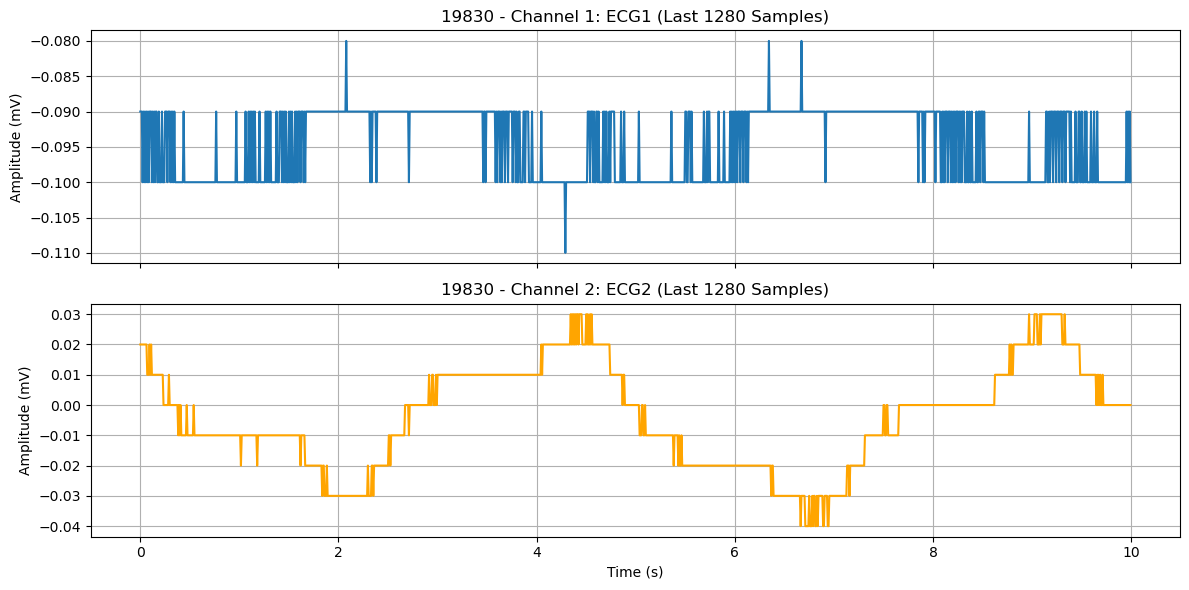

In [44]:
last_samples = signal[-1280:]
time_last_samples = np.arange(len(last_samples)) / fs

fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axs[0].plot(time_last_samples, last_samples[:, 0])
axs[0].set_title(f"{record_name} - Channel 1: {record.sig_name[0]} (Last 1280 Samples)")
axs[0].set_ylabel("Amplitude (mV)")
axs[0].grid(True)

axs[1].plot(time_last_samples, last_samples[:, 1], color='orange')
axs[1].set_title(f"{record_name} - Channel 2: {record.sig_name[1]} (Last 1280 Samples)")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Amplitude (mV)")
axs[1].grid(True)

plt.tight_layout()
plt.show()

They are almost zero values, so we will need to filter for segment of 80 datapoints that are not almost 0. We will do it by adding a treshold for the sum of the datapoints in the interval.